<a href="https://colab.research.google.com/github/geopan2000/Exploring-Mental-Health-Data/blob/main/Mental-Health-Data4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Clone the GitHub repository
!git clone https://github.com/geopan2000/Exploring-Mental-Health-Data.git
!git config --global user.email "giorgosp2000@gmail.com"
!git config --global user.name "Geopan2000"

# Change directory to the cloned repository
%cd Exploring-Mental-Health-Data

fatal: destination path 'Exploring-Mental-Health-Data' already exists and is not an empty directory.
/content/Exploring-Mental-Health-Data/Exploring-Mental-Health-Data


In [35]:
import pandas as pd
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

In [36]:
train_set = pd.read_csv('/content/Exploring-Mental-Health-Data/data/train.csv')
test_set = pd.read_csv('/content/Exploring-Mental-Health-Data/data/test.csv')

In [37]:
train_set.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


# Feature Engineering:


In [38]:
train_id = train_set['id']

target_variable = train_set['Depression']
train_set.drop(columns=['id','Name','Depression'], inplace=True)
test_id = test_set['id']

test_set.drop(columns=['id','Name'], inplace=True)

train_set['Gender'] = train_set['Gender'].map({'Male' : 1, 'Female' : 0}) # Always trasnforming 2 option object types into binary
test_set['Gender'] = test_set['Gender'].map({'Male' : 1, 'Female' : 0})

train_set['Age'] = train_set['Age'] / 100 # Normalized by the Max value
train_set['Age'] = train_set['Age'].fillna(train_set['Age'].mean())
test_set['Age'] = test_set['Age'] / 100
test_set['Age'] = test_set['Age'].fillna(test_set['Age'].mean())

train_set['Working Professional or Student'] = train_set['Working Professional or Student'].map({'Working Professional' : 1, 'Student' : 0}) # Always trasnforming 2 option object types into binary
test_set['Working Professional or Student'] = test_set['Working Professional or Student'].map({'Working Professional' : 1, 'Student' : 0})

train_set['CGPA'] = train_set['CGPA'] /10
train_set['CGPA'] = train_set['CGPA'].fillna(0)
test_set['CGPA'] = test_set['CGPA'] /10
test_set['CGPA'] = test_set['CGPA'].fillna(0)

train_set['Have you ever had suicidal thoughts ?'] = train_set['Have you ever had suicidal thoughts ?'].map({'Yes' : 1, 'No' : 0}) # Always trasnforming 2 option object types into binary
test_set['Have you ever had suicidal thoughts ?'] = test_set['Have you ever had suicidal thoughts ?'].map({'Yes' : 1, 'No' : 0})

train_set['Work/Study Hours'] = train_set['Work/Study Hours'] / 24 # Normalized by the Max value
test_set['Work/Study Hours'] = test_set['Work/Study Hours'] / 24

train_set['Financial Stress'] = train_set['Financial Stress'] / 5 # Normalized by the Max value
train_set['Financial Stress'] = train_set['Financial Stress'].fillna(0)
test_set['Financial Stress'] = test_set['Financial Stress'] / 5
test_set['Financial Stress'] = test_set['Financial Stress'].fillna(0)

train_set['Family History of Mental Illness'] = train_set['Family History of Mental Illness'].map({'Yes' : 1, 'No' : 0}) # Always trasnforming 2 option object types into binary
test_set['Family History of Mental Illness'] = test_set['Family History of Mental Illness'].map({'Yes' : 1, 'No' : 0})

In [39]:
# Create the new feature 'Academic/Work Pressure'
train_set['Academic/Work Pressure'] = train_set.apply(
    lambda row: row['Academic Pressure'] if pd.notna(row['Academic Pressure']) and pd.isna(row['Work Pressure']) else
                row['Work Pressure'] if pd.isna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) else
                (row['Academic Pressure'] + row['Work Pressure']) / 2 if pd.notna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) else
                None,  # Placeholder for rows where both are NaN
    axis=1)

# Fill any remaining NaN in 'Academic/Work Pressure' with its mean
train_set['Academic/Work Pressure'] = train_set['Academic/Work Pressure'].fillna(train_set['Academic/Work Pressure'].mean())

train_set['Academic Pressure'] = train_set['Academic Pressure'] / 5
train_set['Academic Pressure'] = train_set['Academic Pressure'].fillna(0)

train_set['Work Pressure'] = train_set['Work Pressure'] / 5
train_set['Work Pressure'] = train_set['Work Pressure'].fillna(0)

In [40]:
# Create the new feature 'Academic/Work Pressure'
test_set['Academic/Work Pressure'] = test_set.apply(
    lambda row: row['Academic Pressure'] if pd.notna(row['Academic Pressure']) and pd.isna(row['Work Pressure']) else
                row['Work Pressure'] if pd.isna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) else
                (row['Academic Pressure'] + row['Work Pressure']) / 2 if pd.notna(row['Academic Pressure']) and pd.notna(row['Work Pressure']) else
                None,  # Placeholder for rows where both are NaN
    axis=1)

# Fill any remaining NaN in 'Academic/Work Pressure' with its mean
test_set['Academic/Work Pressure'] = test_set['Academic/Work Pressure'].fillna(test_set['Academic/Work Pressure'].mean())

test_set['Academic Pressure'] = test_set['Academic Pressure'] / 5
test_set['Academic Pressure'] = test_set['Academic Pressure'].fillna(0)

test_set['Work Pressure'] = test_set['Work Pressure'] / 5
test_set['Work Pressure'] = test_set['Work Pressure'].fillna(0)

In [41]:
# Create the new feature Study/Job Satisfaction
train_set['Study/Job Satisfaction'] = train_set.apply(
    lambda row: row['Study Satisfaction'] if pd.notna(row['Study Satisfaction']) and pd.isna(row['Job Satisfaction']) else
                row['Job Satisfaction'] if pd.isna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) else
                (row['Study Satisfaction'] + row['Job Satisfaction']) / 2 if pd.notna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) else
                None,  # Placeholder for rows where both are NaN
    axis=1)

# Fill any remaining NaN in Study/Job Satisfaction with its mean
train_set['Study/Job Satisfaction'] = train_set['Study/Job Satisfaction'].fillna(train_set['Study/Job Satisfaction'].mean())

train_set['Study Satisfaction'] = train_set['Study Satisfaction'] / 5
train_set['Study Satisfaction'] = train_set['Study Satisfaction'].fillna(0)

train_set['Job Satisfaction'] = train_set['Job Satisfaction'] / 5
train_set['Job Satisfaction'] = train_set['Job Satisfaction'].fillna(0)

In [42]:
# Create the new feature Study/Job Satisfaction
test_set['Study/Job Satisfaction'] = test_set.apply(
    lambda row: row['Study Satisfaction'] if pd.notna(row['Study Satisfaction']) and pd.isna(row['Job Satisfaction']) else
                row['Job Satisfaction'] if pd.isna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) else
                (row['Study Satisfaction'] + row['Job Satisfaction']) / 2 if pd.notna(row['Study Satisfaction']) and pd.notna(row['Job Satisfaction']) else
                None,  # Placeholder for rows where both are NaN
    axis=1)

# Fill any remaining NaN in Study/Job Satisfaction with its mean
test_set['Study/Job Satisfaction'] = test_set['Study/Job Satisfaction'].fillna(test_set['Study/Job Satisfaction'].mean())

test_set['Study Satisfaction'] = test_set['Study Satisfaction'] / 5
test_set['Study Satisfaction'] = test_set['Study Satisfaction'].fillna(0)

test_set['Job Satisfaction'] = test_set['Job Satisfaction'] / 5
test_set['Job Satisfaction'] = test_set['Job Satisfaction'].fillna(0)

In [43]:
# Combine train and test value counts
train_counts = train_set['City'].value_counts()
test_counts = test_set['City'].value_counts()

# Create a combined count of professions
combined_counts = train_counts.add(test_counts, fill_value=0)

# Identify professions appearing less than 5 times in either set
low_frequency_values = combined_counts[combined_counts < 10].index.tolist()

# Map low-frequency values to 'None' in both train and test sets
train_set['City'] = train_set['City'].apply(lambda x: 'Other' if x in low_frequency_values else x)
test_set['City'] = test_set['City'].apply(lambda x: 'Other' if x in low_frequency_values else x)

In [44]:
# Combine train and test value counts
train_counts = train_set['Profession'].value_counts()
test_counts = test_set['Profession'].value_counts()

# Create a combined count of professions
combined_counts = train_counts.add(test_counts, fill_value=0)

# Identify professions appearing less than 5 times in either set
low_frequency_values = combined_counts[combined_counts < 10].index.tolist()

# Map low-frequency values to 'None' in both train and test sets
train_set['Profession'] = train_set['Profession'].apply(lambda x: 'Other' if x in low_frequency_values else x)
test_set['Profession'] = test_set['Profession'].apply(lambda x: 'Other' if x in low_frequency_values else x)

In [45]:
# Combine train and test value counts
train_counts = train_set['Degree'].value_counts()
test_counts = test_set['Degree'].value_counts()

# Create a combined count of professions
combined_counts = train_counts.add(test_counts, fill_value=0)

# Identify professions appearing less than 5 times in either set
low_frequency_values = combined_counts[combined_counts < 10].index.tolist()

# Map low-frequency values to 'None' in both train and test sets
train_set['Degree'] = train_set['Degree'].apply(lambda x: 'Other' if x in low_frequency_values else x)
test_set['Degree'] = test_set['Degree'].apply(lambda x: 'Other' if x in low_frequency_values else x)

In [46]:
train_set['City'] = train_set['City'].fillna('Other')
freq = train_set['City'].value_counts()
train_set['City_freq'] = train_set['City'].map(freq) # Frequency encoding different cities

test_set['City'] = test_set['City'].fillna('Other')
test_set['City_freq'] = test_set['City'].map(freq) # Frequency encoding different cities


train_set['Degree'] = train_set['Degree'].fillna('Other')
freq = train_set['Degree'].value_counts()
train_set['Degree_freq'] = train_set['Degree'].map(freq) # Frequency encoding

test_set['Degree'] = test_set['Degree'].fillna('Other')
test_set['Degree_freq'] = test_set['Degree'].map(freq) # Frequency encoding


train_set['Profession'] = train_set['Profession'].fillna('Other')
freq = train_set['Profession'].value_counts()
train_set['Profession_freq'] = train_set['Profession'].map(freq) # Frequency encoding

test_set['Profession'] = test_set['Profession'].fillna('Other')
test_set['Profession_freq'] = test_set['Profession'].map(freq) # Frequency encoding

In [47]:
# Save the original number of rows for splitting later
train_size = len(train_set)

# Concatenate train and test sets
concat_set = pd.concat([train_set, test_set], axis=0)

# Apply one-hot encoding to the concatenated set
concat_set = pd.get_dummies(concat_set, columns=['Degree', 'Profession', 'City'])

# Split the concatenated set back into train and test sets
train_set = concat_set.iloc[:train_size, :].copy()  # Get the original train rows
test_set = concat_set.iloc[train_size:, :].copy()   # Get the original test rows

print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)

Train set shape: (140700, 116)
Test set shape: (93800, 116)


In [48]:
 #Define a function to encode Sleep Duration
def encode_sleep_duration(value):
    # Check for NaN or None
    if pd.isna(value):
        return -1  # Placeholder for missing or invalid values

    # Ensure the value is a string
    value = str(value).strip()

    # Encoding logic
    if 'Less than 5 hours' in value or value in ['3-4 hours', '4-5 hours', '2-3 hours']:
        return 1  # < 5 hours
    elif '5-6 hours' in value:
        return 2  # 5-6 hours
    elif '6-7 hours' in value or '6-8 hours' in value:
        return 3  # 6-7 hours
    elif '7-8 hours' in value:
        return 4  # 7-8 hours
    elif 'More than 8 hours' in value or '8-9 hours' in value or '9-11 hours' in value:
        return 5  # > 8 hours
    else:
        return -1  # Placeholder for other invalid or unclear values

sleep_mapping = {
    'More than 8 hours': '>8',
    'Less than 5 hours': '<5',
    'Moderate': '5-6 hours',
    '9-6 hours': '6-9 hours',

    '10-6 hours': '6-10 hours',
    'than 5 hours': '4-6 hours',
    'Unhealthy': '4-6 hours',
    '9-5 hours': '5-9 hours',
    '9-5': '5-9 hours',
    '8-89 hours': '8-9 hours',

    # Ambiguous or irrelevant entries
    'Sleep_Duration': None, '40-45 hours': None, '55-66 hours': None, 'Indore': None,
    '45': None, '35-36 hours': None, 'No': None, 'Indore': None, '49 hours': None,
    'Work_Study_Hours': None, '45-48 hours': None, 'Pune': None, 'Soham': None,
    '0': None, 'Meerut': None, '60-65 hours': None, 'Vivan': None,
    'Have_you_ever_had_suicidal_thoughts': None, '20-21 hours': None, '50-75 hours': None
}

# Define range extraction function
def extract_range(value):
    try:
        if '-' in value:
            parts = value.split('-')
            return int(parts[0]), int(parts[1].split()[0])
        elif '<' in value:
            return 3, 5
        elif '>' in value:
            lower_bound = int(value.split('>')[1].split()[0])
            return lower_bound, 10
        elif value.isdigit():
            num = int(value)
            return num, num
        else:
            return None, None
    except:
        return None, None

In [49]:
train_set['Sleep Duration'] = train_set['Sleep Duration'].map(sleep_mapping)
test_set['Sleep Duration'] = test_set['Sleep Duration'].map(sleep_mapping)

train_set['Sleep_Duration_Encoded'] = train_set['Sleep Duration'].apply(encode_sleep_duration)
test_set['Sleep_Duration_Encoded'] = test_set['Sleep Duration'].apply(encode_sleep_duration)

# Apply the function to create 'From' and 'To' columns
train_set[['From', 'To']] = train_set['Sleep Duration'].apply(lambda x: pd.Series(extract_range(x)))
test_set[['From', 'To']] = test_set['Sleep Duration'].apply(lambda x: pd.Series(extract_range(x)))

# Handle missing values
train_set['From'] = train_set['From'].fillna(train_set['From'].mean())
train_set['To'] = train_set['To'].fillna(train_set['To'].mean())

test_set['From'] = test_set['From'].fillna(test_set['From'].mean())
test_set['To'] = test_set['To'].fillna(test_set['To'].mean())

# Drop the original column if not needed
train_set.drop(columns=['Sleep Duration'], inplace=True)
test_set.drop(columns=['Sleep Duration'], inplace=True)

In [50]:
print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)

Train set shape: (140700, 118)
Test set shape: (93800, 118)


In [51]:
# Define mapping for valid dietary habits
dietary_mapping = {
    'Moderate': 'Moderate',
    'Unhealthy': 'Unhealthy',
    'Healthy': 'Healthy',
    'More Healthy': 'Healthy',
    'Less Healthy': 'Unhealthy',
    'Less than Healthy': 'Unhealthy',
    'No Healthy': 'Unhealthy',
    '3': 'Moderate',
    '1.0': 'Unhealthy',
    '2': 'Moderate',
    '5 Healthy': 'Healthy',
    '5 Unhealthy': 'Unhealthy',

    # Ambiguous or irrelevant entries
    'Yes': None, 'No': None, 'No Healthy': None, 'Class 12': None, 'Indoor': None,
    'Male': None, 'Vegas': None, 'M.Tech': None, 'Electrician': None,
    'Hormonal': None, 'Mihir': None, 'Gender': None, 'BSc': None,
    'Pratham': None, 'Prachi': None, 'Resistant': None, 'Mealy': None,

    'nan': None, 'Academic': None, 'Educational': None, 'Soham': None,
    'Naina': None, 'Kolkata': None, 'Raghav': None, 'Vivaan': None,  'MCA': None,
}

# Apply the mapping to the Dietary Habits column
train_set['Dietary Habits'] = train_set['Dietary Habits'].map(dietary_mapping)
train_set['Dietary Habits'] = train_set['Dietary Habits'].fillna('X')

test_set['Dietary Habits'] = test_set['Dietary Habits'].map(dietary_mapping)
test_set['Dietary Habits'] = test_set['Dietary Habits'].fillna('X')

freq = train_set['Dietary Habits'].value_counts()
train_set['Dietary Habits_freq'] = train_set['Dietary Habits'].map(freq) # frequency encoding
test_set['Dietary Habits_freq'] = test_set['Dietary Habits'].map(freq) # frequency encoding

# Save the original number of rows for splitting later
train_size = len(train_set)

# Concatenate train and test sets
concat_set = pd.concat([train_set, test_set], axis=0)

# Apply one-hot encoding to the concatenated set
concat_set = pd.get_dummies(concat_set, columns=['Dietary Habits'])

# Split the concatenated set back into train and test sets
train_set = concat_set.iloc[:train_size, :].copy()  # Get the original train rows
test_set = concat_set.iloc[train_size:, :].copy()   # Get the original test rows

In [52]:
print("Train set shape:", train_set.shape)
print("Test set shape:", test_set.shape)

Train set shape: (140700, 122)
Test set shape: (93800, 122)


# Last Check before tuning

In [53]:
# Check for columns with object data type in train_set and test_set
train_object_columns = train_set.select_dtypes(include=['object']).columns
test_object_columns = test_set.select_dtypes(include=['object']).columns

print("Object columns in train_set:", train_object_columns.tolist())
print("Object columns in test_set:", test_object_columns.tolist())

# Check for columns with missing values in train_set and test_set
train_missing = train_set.isna().sum()
test_missing = test_set.isna().sum()

print("\nColumns with missing values in train_set:")
print(train_missing[train_missing > 0])

print("\nColumns with missing values in test_set:")
print(test_missing[test_missing > 0])


Object columns in train_set: []
Object columns in test_set: []

Columns with missing values in train_set:
Series([], dtype: int64)

Columns with missing values in test_set:
Series([], dtype: int64)


# Create a validation set

In [54]:
X = train_set.copy()
y = target_variable

# Initial split for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.07, stratify=y, random_state=42)

# Print the count of True and False in both train and validation sets
print("Training set class distribution:\n", y_train.value_counts())
print("Validation set class distribution:\n", y_val.value_counts())

Training set class distribution:
 Depression
0    107073
1     23777
Name: count, dtype: int64
Validation set class distribution:
 Depression
0    8060
1    1790
Name: count, dtype: int64


# Extreme Gradient Boosting

In [ ]:
# Define parameter search space
search_spaces = {
    'learning_rate': Real(0.0001, 0.5, 'uniform'),
    'max_depth': Integer(2, 200),
    'n_estimators': Integer(100, 1000),
}

# Initialize the XGBClassifier model with GPU support
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Use for binary classification
    tree_method='hist',  # Use GPU for training
    verbosity=2
)

kf = KFold(n_splits=3)  # 5-fold cross-validation

# Use 'accuracy' as the scoring metric
optimizer = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=64,
    cv=kf,
    scoring='accuracy',  # Change scoring metric to accuracy
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Fit the optimizer using X_train and y_train
optimizer.fit(X_train, y_train)

# Get cross-validation results
cv_results = optimizer.cv_results_

# Create a DataFrame to sort and filter the best models
results_df = pd.DataFrame(cv_results)
top_5_results = results_df.nlargest(5, 'mean_test_score')  # Get top 5 models by mean test score

# Train each of the top 5 models on the full training data and save them
top_5_models = []
for i, row in top_5_results.iterrows():
    params = row['params']
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        tree_method='hist',
        **params
    )
    model.fit(X_train, y_train)
    top_5_models.append(model)

# Print parameters and scores for the top 5 models
for idx, model in enumerate(top_5_models):
    print(f"Model {idx + 1} parameters: {top_5_results.iloc[idx]['params']}")
    print(f"Model {idx + 1} CV score: {top_5_results.iloc[idx]['mean_test_score']}")

print("Top 5 XGBoost models based on accuracy have been trained and saved.")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

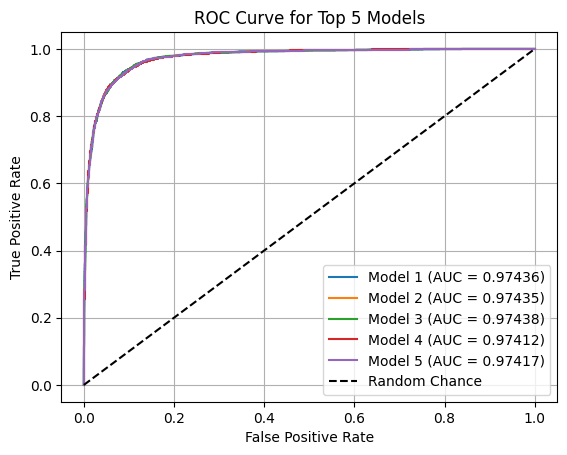

In [56]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_params = [
    {'learning_rate': 0.3162089388136676, 'max_depth': 3, 'n_estimators': 131},
    {'learning_rate': 0.18696571043453358, 'max_depth': 3, 'n_estimators': 132},
    {'learning_rate': 0.45159792579312347, 'max_depth': 2, 'n_estimators': 232},
    {'learning_rate': 0.31724573563187286, 'max_depth': 2, 'n_estimators': 100},
    {'learning_rate': 0.10910495819379294, 'max_depth': 4, 'n_estimators': 136},
]

# Initialize and train models
top_5_models_xgb = []
for params in model_params:
    model = XGBClassifier(**params, eval_metric='error')  # Avoid warnings
    model.fit(X_train, y_train)  # Ensure X_train and y_train are defined
    top_5_models_xgb.append(model)

# Assuming X_val and y_val are your validation features and target
for idx, model in enumerate(top_5_models_xgb):
    y_pred_proba = model.predict_proba(X_val)[:, 1]  # Predicted probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Model {idx + 1} (AUC = {roc_auc:.5f})')

# Plot baseline and finalize ROC curve
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Top 5 Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


0.9398984771573604


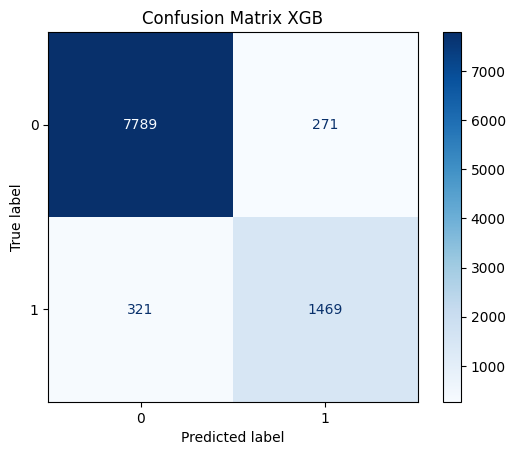

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = top_5_models_xgb[0] #choose the model here 0-4
y_pred = best_model.predict(X_val)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)
print(accuracy_score(y_val, y_pred))
# Plot confusion matrix with colors
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix XGB")
plt.show()


# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import pandas as pd

# Define parameter search space
search_spaces = {
    'n_estimators': Integer(100, 1000),  # Number of trees
    'max_depth': Integer(2, 400),        # Maximum depth of trees
}

# Initialize the RandomForestClassifier model
model = RandomForestClassifier(random_state=42)

# Use 5-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Use 'accuracy' as the scoring metric
optimizer = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=64,           # Number of parameter sets to try
    cv=kf,                # Cross-validation strategy
    scoring='accuracy',   # Scoring metric
    verbose=1,
    n_jobs=-1,            # Use all available cores
    return_train_score=True
)

# Fit the optimizer using X_train and y_train
optimizer.fit(X_train, y_train)

# Get cross-validation results
cv_results = optimizer.cv_results_

# Create a DataFrame to sort and filter the best models
results_df = pd.DataFrame(cv_results)
top_5_results = results_df.nlargest(5, 'mean_test_score')  # Get top 15 models by mean test score

# Train each of the top 15 models on the full training data and save them
top_5_models = []
for i, row in top_5_results.iterrows():
    params = row['params']
    model = RandomForestClassifier(random_state=42, **params)
    model.fit(X_train, y_train)
    top_5_models.append(model)

# Print parameters and scores for the top 15 models
for idx, model in enumerate(top_5_models):
    print(f"Model {idx + 1} parameters: {top_5_results.iloc[idx]['params']}")
    print(f"Model {idx + 1} CV score: {top_5_results.iloc[idx]['mean_test_score']}")

print("Top 5 Random Forest models based on accuracy have been trained and saved.")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

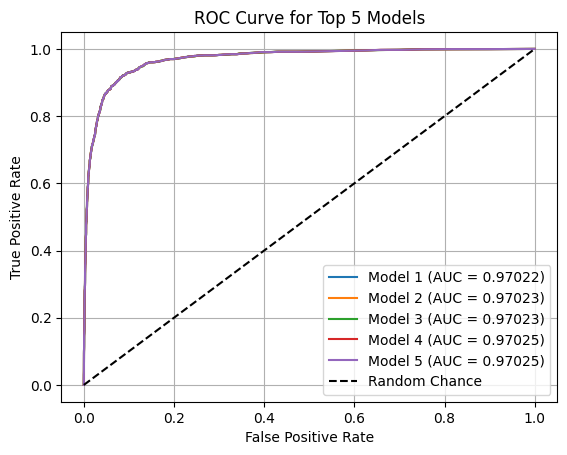

In [59]:
from sklearn.ensemble import RandomForestClassifier

model_params = [
    {'max_depth': 400, 'n_estimators': 947},
    {'max_depth': 392, 'n_estimators': 943},
    {'max_depth': 104, 'n_estimators': 968},
    {'max_depth': 307, 'n_estimators': 1000},
    {'max_depth': 90, 'n_estimators': 1000},

]

# Initialize and train models
top_5_models_rf = []
for params in model_params:
    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    top_5_models_rf.append(model)

# Assuming X_val and y_val are your validation features and target
for idx, model in enumerate(top_5_models_rf):
    y_pred_proba = model.predict_proba(X_val)[:, 1]  # Predicted probabilities for the positive class
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Model {idx + 1} (AUC = {roc_auc:.5f})')

# Plot baseline and finalize ROC curve
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Top 5 Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


0.9368527918781726


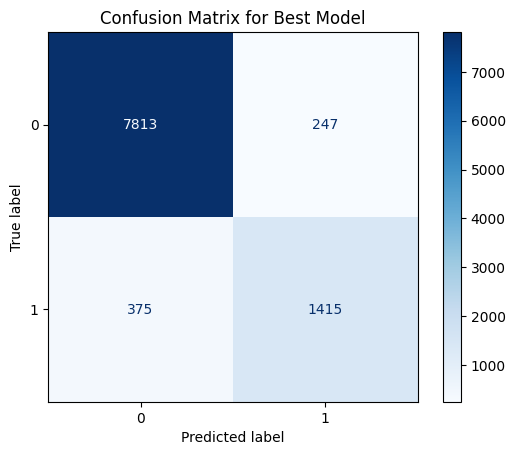

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = top_5_models_rf[4] #choose the model here 0-4
y_pred = best_model.predict(X_val)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)
print(accuracy_score(y_val, y_pred))
# Plot confusion matrix with colors
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best Model")
plt.show()


# Logistic Regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Validation Accuracy: 0.9358


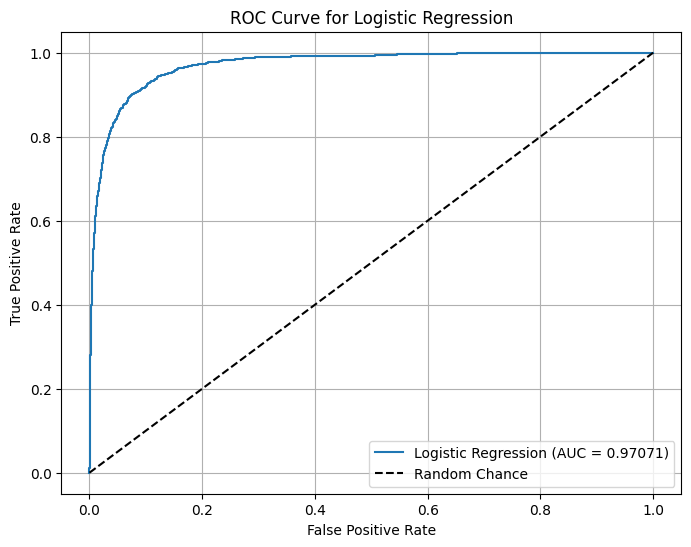

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# Define and train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence
logistic_model.fit(X_train, y_train)  # Train the model on training data

# Make predictions and evaluate the model
y_pred = logistic_model.predict(X_val)  # Predicted labels
y_pred_proba = logistic_model.predict_proba(X_val)[:, 1]  # Predicted probabilities for positive class

# Accuracy score
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.5f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


0.9358375634517766


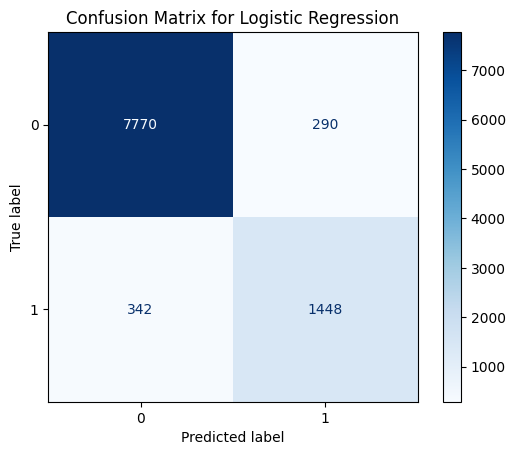

In [63]:
y_pred = logistic_model.predict(X_val)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)
print(accuracy_score(y_val, y_pred))
# Plot confusion matrix with colors
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# MLP

In [69]:
import numpy as np

X_train_mlp = np.array(X_train).astype('float32')  # Ensure features are float32
y_train_mlp = np.array(y_train).astype('float32')  # Labels should be float32 or int32
X_val_mlp = np.array(X_val).astype('float32')      # Validation features
y_val_mlp = np.array(y_val).astype('float32')      # Validation labels
X_test_mlp = np.array(test_set).astype('float32')  # Test features

Epoch 1/700
512/512 [==============================] - 3s 4ms/step - loss: 17.5352 - accuracy: 0.7856 - val_loss: 1.3453 - val_accuracy: 0.8302
Epoch 2/700
512/512 [==============================] - 2s 4ms/step - loss: 2.2290 - accuracy: 0.7931 - val_loss: 2.1132 - val_accuracy: 0.8271
Epoch 3/700
512/512 [==============================] - 2s 3ms/step - loss: 0.9152 - accuracy: 0.8113 - val_loss: 1.5439 - val_accuracy: 0.6784
Epoch 4/700
512/512 [==============================] - 2s 3ms/step - loss: 0.5587 - accuracy: 0.8202 - val_loss: 1.7387 - val_accuracy: 0.7226
Epoch 5/700
512/512 [==============================] - 2s 3ms/step - loss: 0.4208 - accuracy: 0.8303 - val_loss: 0.3720 - val_accuracy: 0.8355
Epoch 6/700
512/512 [==============================] - 2s 3ms/step - loss: 0.3859 - accuracy: 0.8338 - val_loss: 0.3604 - val_accuracy: 0.8360
Epoch 7/700
512/512 [==============================] - 2s 3ms/step - loss: 0.3709 - accuracy: 0.8376 - val_loss: 0.3506 - val_accuracy: 0.842

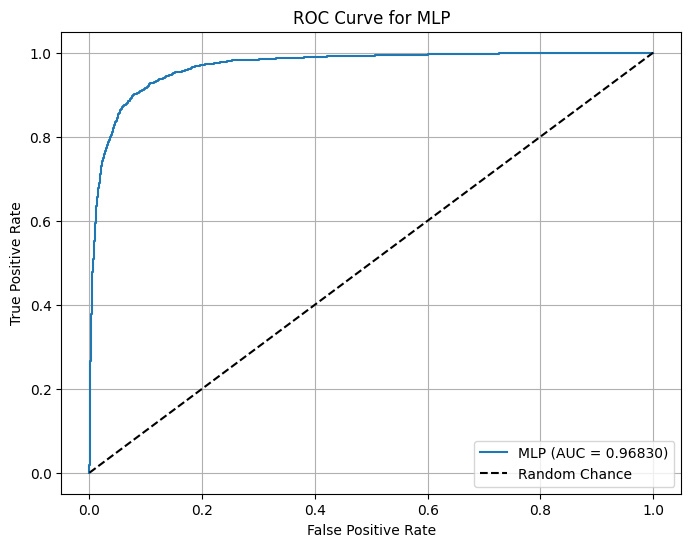

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import Dropout
model_mlp = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    #Dropout(0.2),  # Drop 20% of neurons randomly
    Dense(64, activation='relu'),
    #Dropout(0.2),  # Drop 20% of neurons randomly
    Dense(128, activation='relu'),
    #Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    #Dropout(0.2),  # Drop 20% of neurons randomly
    Dense(1, activation='sigmoid')
])
#, kernel_regularizer=tf.keras.regularizers.l2(0.01)

# Compile the model
model_mlp.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with verbose output
history = model_mlp.fit(
    X_train_mlp, y_train_mlp,
    validation_data=(X_val_mlp, y_val_mlp),
    epochs=700,
    batch_size=256,
    verbose=1  # Verbose mode: 1 for detailed output
)

# Evaluate the model
loss, accuracy = model_mlp.evaluate(X_val_mlp, y_val_mlp, verbose=1)  # Verbose here too
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot ROC Curve
y_pred_proba = model_mlp.predict(X_val_mlp).ravel()
fpr, tpr, _ = roc_curve(y_val_mlp, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"MLP (AUC = {roc_auc:.5f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MLP')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [73]:
# Collect predictions for each trained model
y_pred_proba_train = np.zeros((X_train.shape[0], 12))
y_pred_proba_val = np.zeros((X_val.shape[0], 12))
y_pred_proba_test = np.zeros((test_set.shape[0], 12))

for i, model in enumerate(top_5_models_xgb):  # Iterate over the list of trained models
    y_pred_proba_train[:, i] = model.predict_proba(X_train)[:, 1]  # Store train predictions
    y_pred_proba_val[:, i] = model.predict_proba(X_val)[:, 1]      # Store validation predictions
    y_pred_proba_test[:, i] = model.predict_proba(test_set)[:, 1]  # Store test predictions

# Collect predictions for each Random Forest model
for i, model in enumerate(top_5_models_rf):
    y_pred_proba_train[:, i + 5] = model.predict_proba(X_train)[:, 1]  # Train predictions
    y_pred_proba_val[:, i + 5] = model.predict_proba(X_val)[:, 1]      # Validation predictions
    y_pred_proba_test[:, i + 5] = model.predict_proba(test_set)[:, 1]  # Test predictions

# MLP predictions
y_pred_proba_train[:, 10] = model_mlp.predict(X_train_mlp).ravel()
y_pred_proba_val[:, 10] = model_mlp.predict(X_val_mlp).ravel()
y_pred_proba_test[:, 10] = model_mlp.predict(X_test_mlp).ravel()

# Logistic Regressor:
y_pred_proba_train[:, 11] = logistic_model.predict_proba(X_train)[:, 1]
y_pred_proba_val[:, 11] = logistic_model.predict_proba(X_val)[:, 1]
y_pred_proba_test[:, 11] = logistic_model.predict_proba(test_set)[:, 1]

2932/2932 [==============================] - 4s 1ms/step


# Logistic Regression Meta Model

In [75]:
# Train an ensemble model
# Define and train the Logistic Regression model
ensemble_model = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence
ensemble_model.fit(y_pred_proba_val, y_val)

y_pred_ens_train = ensemble_model.predict(y_pred_proba_train)
y_pred_ens_val = ensemble_model.predict(y_pred_proba_val)
y_pred_ens_test = ensemble_model.predict(y_pred_proba_test)

print("Classification Report - Meta Model (Validation Set):")
print(classification_report(y_val, y_pred_ens_val))

from google.colab import files
# Prepare the output DataFrame
output = pd.DataFrame({'id': test_id.values, 'loan_status': y_pred_ens_test})

# Remove any duplicate rows by 'PassengerId'
output.drop_duplicates(subset='id', keep='first', inplace=True)

# Save predictions to a CSV file
output.to_csv('predictions.csv', index=False)
files.download('predictions.csv')

Classification Report - Meta Model (Validation Set):
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      8060
           1       0.85      0.79      0.82      1790

    accuracy                           0.94      9850
   macro avg       0.90      0.88      0.89      9850
weighted avg       0.94      0.94      0.94      9850



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# XGB Meta Model

In [81]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Train an XGBoost ensemble model
ensemble_model = XGBClassifier(max_depth=7, n_estimators=500, learning_rate=0.01, use_label_encoder=False, eval_metric="error")
ensemble_model.fit(y_pred_proba_val, y_val)  # Train on validation probabilities

# Make predictions on train, validation, and test sets
y_pred_ens_train = ensemble_model.predict(y_pred_proba_train)
y_pred_ens_val = ensemble_model.predict(y_pred_proba_val)
y_pred_ens_test = ensemble_model.predict(y_pred_proba_test)

# Evaluate on the validation set
print("Classification Report - Meta Model (Validation Set):")
print(classification_report(y_val, y_pred_ens_val))

# Save predictions to a CSV file for the test set
output = pd.DataFrame({'id': test_id.values, 'loan_status': y_pred_ens_test})

# Remove any duplicate rows by 'id' (if necessary)
output.drop_duplicates(subset='id', keep='first', inplace=True)

# Save the predictions to a CSV file
output.to_csv('predictions.csv', index=False)

from google.colab import files
files.download('predictions.csv')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:16:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report - Meta Model (Validation Set):
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      8060
           1       0.90      0.86      0.88      1790

    accuracy                           0.96      9850
   macro avg       0.94      0.92      0.93      9850
weighted avg       0.96      0.96      0.96      9850



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Simple Strategy (Average Predictions)

In [77]:
# Compute average probabilities for train, validation, and test
y_pred_proba_train_avg = y_pred_proba_train.mean(axis=1)
y_pred_proba_val_avg = y_pred_proba_val.mean(axis=1)
y_pred_proba_test_avg = y_pred_proba_test.mean(axis=1)

# Apply a threshold to convert probabilities into binary predictions
threshold = 0.5
y_pred_train = (y_pred_proba_train_avg >= threshold).astype(int)
y_pred_val = (y_pred_proba_val_avg >= threshold).astype(int)
y_pred_test = (y_pred_proba_test_avg >= threshold).astype(int)

print("Classification Report - Meta Model (Validation Set):")
print(classification_report(y_val, y_pred_val))

from google.colab import files
# Prepare the output DataFrame
output = pd.DataFrame({'id': test_id.values, 'loan_status': y_pred_test})

# Remove any duplicate rows by 'PassengerId'
output.drop_duplicates(subset='id', keep='first', inplace=True)

# Save predictions to a CSV file
output.to_csv('predictions.csv', index=False)
files.download('predictions.csv')

Classification Report - Meta Model (Validation Set):
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      8060
           1       0.85      0.81      0.83      1790

    accuracy                           0.94      9850
   macro avg       0.91      0.89      0.90      9850
weighted avg       0.94      0.94      0.94      9850



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>